# Análisis del texto de los tweets relacionados con tema electoral y sentimiento de usuarios por comunidad autónoma

En este notebook realizamos un análisis de texto de los tweets que se escribieron en la campaña de abril 2019 y un análisis de sentimiento muy sencillo para los usuarios con comunidad autónoma conocida. 

Empezamos por tener en cuenta únicamente los tweets con Comunidad Autónoma. 

Continuamos por seleccionar únicamente los tweets que hablan de un sólo partido político, desprendiéndonos de los que hablan de más de un partido y de los que no hablan de ninguno, o por lo menos, no con sus siglas.

Realizamos algunos cálculos y análisis antes de llegar a los sentimientos propiamente dichos. 



In [1]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import string
from collections import Counter

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.probability import FreqDist
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import boto3

BUCKET_NAME = 'electomedia' 

# sustituir por credenciales de acceso. 
s3 = boto3.resource('s3', aws_access_key_id = 'XXXXXXX', 
                          aws_secret_access_key= 'XXXXXXXXXXXXX')

In [3]:
import botocore.exceptions

KEY = 'EstimacionOtrasFuentes/A19_twitter_comunidades.csv' 

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'A19_twitter_comunidades.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [4]:
df= pd.read_csv('A19_twitter_comunidades.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340210 entries, 0 to 340209
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          340210 non-null  int64 
 1   Datetime            340210 non-null  object
 2   Tweet Id            340210 non-null  int64 
 3   Text                340210 non-null  object
 4   user_id             340210 non-null  int64 
 5   followers_count     340210 non-null  int64 
 6   friends_count       340210 non-null  int64 
 7   retweet_count       340210 non-null  int64 
 8   reply_count         340210 non-null  int64 
 9   like_count          340210 non-null  int64 
 10  language            340210 non-null  object
 11  comunidad_autonoma  340210 non-null  object
dtypes: int64(8), object(4)
memory usage: 31.1+ MB


In [6]:
df= df.drop(['Unnamed: 0'],axis=1)

In [7]:
df_ca=df[df['comunidad_autonoma']!='unknown']         

In [7]:
#df_ca.info()

In [8]:
df_ca['comunidad_autonoma'].value_counts()

madrid                 35843
catalunya              32386
andalucia              23675
comunidadvalenciana    12388
galicia                 7383
castillaleon            6355
baleares                5870
euskadi                 4780
castillalamancha        3579
asturias                3475
murcia                  3441
aragon                  3401
canarias                3347
extremadura             2121
cantabria               1419
navarra                 1177
larioja                  802
melilla                  240
ceuta                    205
Name: comunidad_autonoma, dtype: int64

In [10]:
#df_ca.groupby(['comunidad_autonoma']).nunique().sort_values('user_id', ascending= False)

,Unnamed: 0,Datetime,Tweet Id,Text,Username,user_id,followers_count,friends_count,retweet_count,reply_count,like_count,language,comunidad_autonoma
comunidad_autonoma,,,,,,,,,,,,,
catalunya,32376,27941,32376,32213,12005,12005,4240,3523,262,93,418,32,1
madrid,35843,30594,35843,35677,11830,11830,4760,3258,326,118,501,32,1
andalucia,23675,20833,23675,23572,8557,8557,3107,2545,176,63,263,25,1
comunidadvalenciana,12374,11728,12374,12330,4435,4435,2200,2038,126,36,190,24,1
galicia,7383,7063,7383,7348,2581,2581,1571,1492,106,33,155,22,1
castillaleon,6355,6137,6355,6351,2296,2296,1455,1360,72,26,112,18,1
canarias,6001,5712,6001,5970,1952,1952,1238,1231,73,27,109,16,1
euskadi,4780,4642,4780,4770,1570,1570,1117,1071,98,31,139,16,1
murcia,3441,3369,3441,3433,1261,1261,962,945,63,26,102,16,1


In [11]:
#df_ca.head()

In [9]:
df_ca['psoe']= df_ca['Text'].str.contains('psoe', flags=re.IGNORECASE, regex=True)
df_ca['UP']= df_ca['Text'].str.contains('UP', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('unidaspodemos', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('podemos', flags=re.IGNORECASE, regex=True)
df_ca['vox']= df_ca['Text'].str.contains('vox', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('abascal', flags=re.IGNORECASE, regex=True)
df_ca['Cs']= df_ca['Text'].str.contains('ciudadanos', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('cs', flags=re.IGNORECASE, regex=True)
df_ca['PP']=df_ca['Text'].str.contains('PP', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('populares', flags=re.IGNORECASE, regex=True)

In [10]:
psoe= df_ca['Text'].str.contains('psoe', flags=re.IGNORECASE, regex=True)
UP= df_ca['Text'].str.contains('UP', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('unidaspodemos', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('podemos', flags=re.IGNORECASE, regex=True)
vox= df_ca['Text'].str.contains('vox', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('abascal', flags=re.IGNORECASE, regex=True)
Cs= df_ca['Text'].str.contains('ciudadanos', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('cs', flags=re.IGNORECASE, regex=True)
PP=df_ca['Text'].str.contains('PP', flags=re.IGNORECASE, regex=True)| df_ca['Text'].str.contains('populares', flags=re.IGNORECASE, regex=True)

In [11]:
df_ca['TextPartido']= np.where(psoe, 'psoe', 
                                  np.where(UP, 'UP',
                                           np.where(PP, 'partidopopular',
                                                    np.where(vox, 'vox',
                                                             np.where(Cs, 'ciudadanos','unknown')))))

In [16]:
#df_ca.head(10)

In [12]:
df_ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151887 entries, 0 to 340208
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Datetime            151887 non-null  object
 1   Tweet Id            151887 non-null  int64 
 2   Text                151887 non-null  object
 3   user_id             151887 non-null  int64 
 4   followers_count     151887 non-null  int64 
 5   friends_count       151887 non-null  int64 
 6   retweet_count       151887 non-null  int64 
 7   reply_count         151887 non-null  int64 
 8   like_count          151887 non-null  int64 
 9   language            151887 non-null  object
 10  comunidad_autonoma  151887 non-null  object
 11  psoe                151887 non-null  bool  
 12  UP                  151887 non-null  bool  
 13  vox                 151887 non-null  bool  
 14  Cs                  151887 non-null  bool  
 15  PP                  151887 non-null  bool  
 16  Te

In [13]:
#quitamos los tweets que hablan de más de un partido. versión 1. versiones anteriores buscaríamos cómo analizarlos. 
df_ca_new= df_ca.drop(df_ca[(df_ca['psoe']== True) & (df_ca['UP']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['psoe']== True) & (df_ca_new['vox']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['psoe']== True) & (df_ca_new['Cs']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['psoe']== True) & (df_ca_new['PP']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['UP']== True) & (df_ca_new['vox']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['UP']== True) & (df_ca_new['Cs']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['UP']== True) & (df_ca_new['PP']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['vox']== True) & (df_ca_new['Cs']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['PP']== True) & (df_ca_new['vox']== True)].index)
df_ca_new= df_ca_new.drop(df_ca_new[(df_ca_new['PP']== True) & (df_ca_new['Cs']== True)].index)


In [18]:
df_ca_new['comunidad_autonoma'].value_counts()

madrid                 29795
catalunya              27883
andalucia              20246
comunidadvalenciana    10601
galicia                 6254
castillaleon            5385
baleares                5009
euskadi                 4064
asturias                2915
castillalamancha        2914
murcia                  2898
aragon                  2867
canarias                2856
extremadura             1804
cantabria               1197
navarra                  992
larioja                  701
melilla                  202
ceuta                    166
Name: comunidad_autonoma, dtype: int64

In [19]:
df_ca_new['TextPartido'].value_counts()

unknown           58075
vox               29375
psoe              13500
UP                11653
partidopopular     9422
ciudadanos         6724
Name: TextPartido, dtype: int64

In [20]:
df_ca_partidos= df_ca_new[df_ca_new['TextPartido']!='unknown']

In [21]:
print(df_ca_partidos.shape)
df_ca_new.shape


(70674, 17)


(128749, 17)

Una vez seleccionados los tweets que nos interesan, jugamos con una visualización temporal. 

In [22]:
df_ca_partidos['Datetime'] = pd.to_datetime(df_ca_partidos['Datetime'])
#df_ca_partidos.head(3)

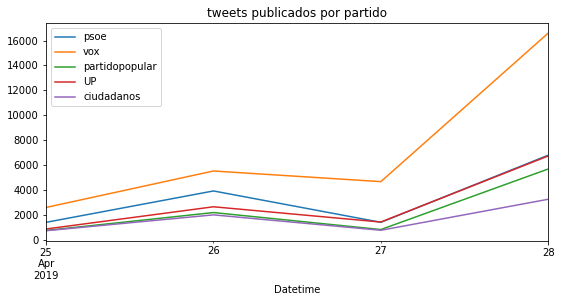

In [23]:
# Distribución temporal de los tweets,CORREGIR COLORES
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for TextPartido in df_ca_partidos.TextPartido.unique():
    df_temp = df_ca_partidos[df_ca_partidos['TextPartido'] == TextPartido].copy()
    df_temp['Datetime'] = pd.to_datetime(df_temp['Datetime'].dt.strftime('%Y-%m-%d'))
    df_temp = df_temp.groupby(df_temp['Datetime']).size()
    df_temp.plot(label=TextPartido, ax=ax)

ax.set_title('tweets publicados por partido')
ax.legend();

Y empezamos la limpieza del texto de los tweets: 

In [24]:
def limpiar_tokenizar(texto):
     
    # Se convierte todo el texto a minúsculas, si quedara algo.
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación, no nos importa perder ni # ni @
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo "
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo 
['esto', 'es', 'ejemplo']


In [25]:
# Aplicamos la función  a cada tweet

df_ca_partidos['texto_tokenizado'] = df_ca_partidos['Text'].apply(lambda x: limpiar_tokenizar(x))
df_ca_partidos[['Text', 'texto_tokenizado']].head()

,Text,texto_tokenizado
0,"@carmencalvo_ @myriamsempere @psoe muy fan de la camiseta, pero mucho mas de tu feminismo, brillantez y valentia. enhorabuena.","[carmencalvo, myriamsempere, psoe, muy, fan, de, la, camiseta, pero, mucho, mas, de, tu, feminismo, brillantez, valentia, enhorabuena]"
2,@rabascoficial @marinadoate @vox_es a ti te lo voy a decir. que quiero ser ministro algun dia y estos tweets los carga el diablo,"[rabascoficial, marinadoate, vox, es, ti, te, lo, voy, decir, que, quiero, ser, ministro, algun, dia, estos, tweets, los, carga, el, diablo]"
4,"@vox_es el paso ha sido grande pero no llegaremos a un futuro en las manos que quedamos,este pais esta muy ciego.en las calles se ve,perro flautas vagos, inmigrantes delincuentes y con mas derecho que los espanoles y a otros los que explotan y nos quitan el trabajo y muchos separatistas.","[vox, es, el, paso, ha, sido, grande, pero, no, llegaremos, un, futuro, en, las, manos, que, quedamos, este, pais, esta, muy, ciego, en, las, calles, se, ve, perro, flautas, vagos, inmigrantes, delincuentes, con, mas, derecho, que, los, espanoles, otros, los, que, explotan, nos, quitan, el, trabajo, muchos, separatistas]"
7,@andinocuadras @santi_abascal @vox_es vivo ejemplo de politico frustrado sin la mas minima pu&amp;@ idea de las pendejadas que escribe en twitter.... esto es un pecado dios!!!!,"[andinocuadras, santi, abascal, vox, es, vivo, ejemplo, de, politico, frustrado, sin, la, mas, minima, pu, amp, idea, de, las, pendejadas, que, escribe, en, twitter, esto, es, un, pecado, dios]"
30,@sanchezcastejon @psoe con rivera no,"[sanchezcastejon, psoe, con, rivera, no]"


In [26]:
# Separo por palabra la columna texto_tokenizado

tweets_tidy = df_ca_partidos.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='Text')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,Datetime,Tweet Id,user_id,followers_count,friends_count,retweet_count,reply_count,like_count,language,comunidad_autonoma,psoe,UP,vox,Cs,PP,TextPartido,token
0,2019-04-28 23:59:59+00:00,1122651707689918465,14102996,2683,997,0,1,6,es,andalucia,True,False,False,False,False,psoe,carmencalvo
0,2019-04-28 23:59:59+00:00,1122651707689918465,14102996,2683,997,0,1,6,es,andalucia,True,False,False,False,False,psoe,myriamsempere
0,2019-04-28 23:59:59+00:00,1122651707689918465,14102996,2683,997,0,1,6,es,andalucia,True,False,False,False,False,psoe,psoe


Algunos juegos con las palabras: 

In [29]:
# Palabras totales utilizadas por cada partido

print('--------------------------')
print('Palabras totales por partido')
print('--------------------------')
print(tweets_tidy.groupby(by='TextPartido')['token'].count())

# Palabras distintas utilizadas por cada partido
# ==============================================================================
print('----------------------------')
print('Palabras distintas por partido')
print('----------------------------')
tweets_tidy.groupby(by='TextPartido')['token'].nunique()

--------------------------
Palabras totales por partido
--------------------------
TextPartido
UP                247212
ciudadanos        134558
partidopopular    169170
psoe              250221
vox               536461
Name: token, dtype: int64
----------------------------
Palabras distintas por partido
----------------------------


TextPartido
UP                25206
ciudadanos        17009
partidopopular    18892
psoe              25178
vox               39108
Name: token, dtype: int64

In [30]:
# Longitud media y desviación de los tweets de cada partido

temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["TextPartido", "Tweet Id"])["token"].count())
temp_df.reset_index().groupby("TextPartido")["token"].agg(['mean', 'std'])

,mean,std
TextPartido,,
UP,21.214451,13.002776
ciudadanos,20.014131,11.659746
partidopopular,17.956056,11.309353
psoe,18.534889,11.771633
vox,18.262563,12.646415


In [30]:
# listado de stopwords de nltk (otro punto mejorable en futuras versiones)

stop_words = list(stopwords.words('spanish'))

print(stop_words[:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


In [31]:
# Filtrado para excluir stopwords

tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]


In [32]:
# Top 5 palabras más utilizadas por cada partido, en tabla

tweets_tidy.groupby(['TextPartido','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('TextPartido') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

TextPartido                token  count
TextPartido                                                      
UP             720                 UP         ahorapodemos   5114
               7764                UP  eleccionesgenerales   2602
               18088               UP              podemos   1818
               23620               UP        unidaspodemos   1646
               21492               UP                   si   1586
ciudadanos     27855       ciudadanos         ciudadanoscs   3718
               38960       ciudadanos               rivera   1473
               25557       ciudadanos               albert   1376
               27853       ciudadanos           ciudadanos   1041
               30448       ciudadanos  eleccionesgenerales   1008
partidopopular 55567   partidopopular            populares   5838
               55690   partidopopular                   pp   2965
               54473   partidopopular          pablocasado   2600
               47786   partidopopular  eleccionesgenerales   1557
               59742   partidopopular          valorseguro    907
psoe           79872             psoe                 psoe  12819
               81939             psoe      sanchezcastejon   4557
               71592             psoe           hazquepase   1762
               85149             psoe             votapsoe   1703
               68319             psoe  eleccionesgenerales   1440
vox            123673             vox                  vox  31843
               85593              vox              abascal   4833
               118540             vox                santi   3773
               119223             vox                   si   3223
               99078              vox               espana   2613

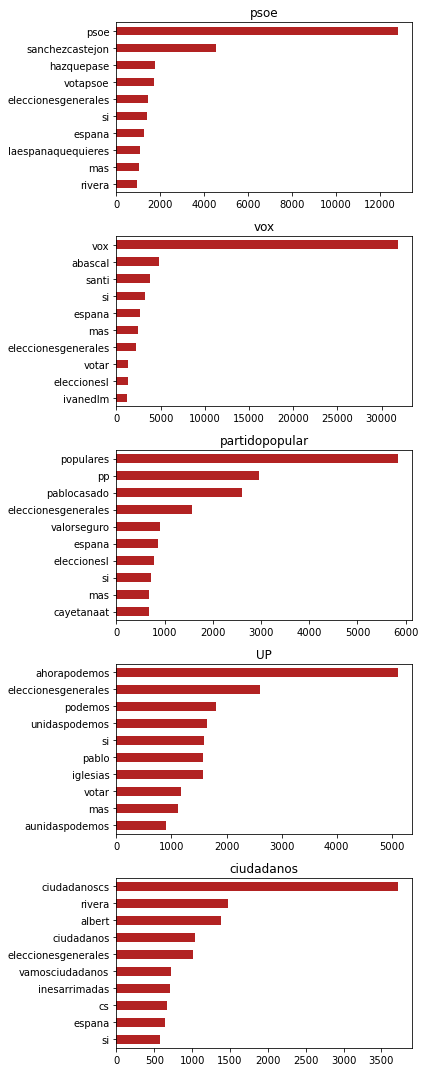

In [37]:
# Top 10 palabras por partido en gráfica. 
#una de las cosas más llamativas quizá es la aparición de rivera en el listado del PSOE...
#era el momento en el que se debatía la posibilidad de coalición PSOE-Cs

fig, axs = plt.subplots(nrows=5, ncols=1,figsize=(6, 15))
for i, TextPartido in enumerate(tweets_tidy.TextPartido.unique()):
    df_temp = tweets_tidy[tweets_tidy.TextPartido == TextPartido]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(TextPartido)

fig.tight_layout()

In [38]:
# Pivotado de datos

tweets_pivot = tweets_tidy.groupby(["TextPartido","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="TextPartido", values= "count")
tweets_pivot.columns.name = None

In [39]:
# Test de correlación (coseno) por el uso y frecuencia de palabras

from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,UP,ciudadanos,partidopopular,psoe,vox
UP,1.000000,0.615206,0.602097,0.530798,0.677613
ciudadanos,0.615206,1.000000,0.483321,0.508816,0.538433
partidopopular,0.602097,0.483321,1.000000,0.426463,0.545604
psoe,0.530798,0.508816,0.426463,1.000000,0.510486
vox,0.677613,0.538433,0.545604,0.510486,1.000000


TypeError: annotate() missing 1 required positional argument: 's'

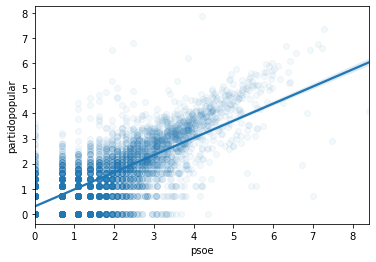

In [40]:
# Gráfico de correlación

f, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.psoe),
    y  = np.log(temp.partidopopular),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.psoe[i]), np.log(temp.partidopopular[i])),
        alpha = 0.7
    )

## Análisis de sentimiento 

Una forma de analizar el sentimiento de un texto es considerando su sentimiento como la suma de los sentimientos de cada una de las palabras que lo forman. 
Esta no es la única forma de abordar el análisis de sentimientos, pero consigue un buen equilibrio entre complejidad y resultado, siempre que se cuente con un buen lexicon.

Para llevar a cabo esta técnica aproximación es necesario disponer de un diccionario en el que se asocie a cada palabra un sentimiento o nivel de sentimiento. Uno de los más utilizados en inglés es AFINN (asigna a cada palabra un valor entre -5 y 5). 
Localizamos en internet una adaptación al español que, como el propio autor indica, está hecha de manera automática y con correcciones sucesivas pero no es perfecto.  
https://github.com/jboscomendoza/lexicos-nrc-afinn/blob/master/lexico_afinn.csv

En versiones futuras sería interesante utilizar un elemento de aws, el ground truth, que va aprendiendo del etiquetado que uno realiza y ayuda a completar un set de entrenamiento más rápido. 

In [41]:
# carga lexicon sentimientos

lexicon = pd.read_csv('lexico_afinn_es.csv', delimiter= ';')
lexicon.head()

,palabra,puntuacion
0,culpa,-2.0
1,culpar,-2.0
2,aborda,1.0
3,abordo,1.0
4,abandona,-2.0


Sentimiento promedio de cada tweet

Al disponer de los datos en formato tidy (una palabra por fila), mediante un inner join se añade a cada palabra su sentimiento y se filtran automáticamente todas aquellas palabras para las que no hay información disponible.


In [78]:
# Sentimiento promedio de cada tweet

tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "palabra",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "palabra")



In [79]:
tweets_sentimientos['positivo'] = tweets_sentimientos['puntuacion']>0

In [80]:
tweets_sentimientos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73211 entries, 0 to 73210
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Datetime            73211 non-null  datetime64[ns, UTC]
 1   Tweet Id            73211 non-null  int64              
 2   user_id             73211 non-null  int64              
 3   followers_count     73211 non-null  int64              
 4   friends_count       73211 non-null  int64              
 5   retweet_count       73211 non-null  int64              
 6   reply_count         73211 non-null  int64              
 7   like_count          73211 non-null  int64              
 8   language            73211 non-null  object             
 9   comunidad_autonoma  73211 non-null  object             
 10  psoe                73211 non-null  bool               
 11  UP                  73211 non-null  bool               
 12  vox                 73211 non-nu

In [81]:
tweets_sentimientos.positivo.value_counts()

True     39604
False    33607
Name: positivo, dtype: int64

In [82]:
tweets_sentimientos_positivos=tweets_sentimientos[tweets_sentimientos['positivo']== True]

In [83]:
tweets_sentimientos_positivos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39604 entries, 0 to 73210
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Datetime            39604 non-null  datetime64[ns, UTC]
 1   Tweet Id            39604 non-null  int64              
 2   user_id             39604 non-null  int64              
 3   followers_count     39604 non-null  int64              
 4   friends_count       39604 non-null  int64              
 5   retweet_count       39604 non-null  int64              
 6   reply_count         39604 non-null  int64              
 7   like_count          39604 non-null  int64              
 8   language            39604 non-null  object             
 9   comunidad_autonoma  39604 non-null  object             
 10  psoe                39604 non-null  bool               
 11  UP                  39604 non-null  bool               
 12  vox                 39604 non-nu

Ahora que ya tenemos las palabras de los tweets con sentimiento positivo, tenemos que filtrar para si hay más de una palabra positiva por tweet que cuente como uno solo y además filtrar por usuario. si un usuario tiene varios tweets positivos nos quedamos con el primero. Lo dicho, a revisar en versiones futuras. 

In [84]:
#primero tweet id repetido:
df_unique_tweet = tweets_sentimientos_positivos.drop_duplicates(subset=['Tweet Id'])

In [85]:
df_unique_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22796 entries, 0 to 73205
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Datetime            22796 non-null  datetime64[ns, UTC]
 1   Tweet Id            22796 non-null  int64              
 2   user_id             22796 non-null  int64              
 3   followers_count     22796 non-null  int64              
 4   friends_count       22796 non-null  int64              
 5   retweet_count       22796 non-null  int64              
 6   reply_count         22796 non-null  int64              
 7   like_count          22796 non-null  int64              
 8   language            22796 non-null  object             
 9   comunidad_autonoma  22796 non-null  object             
 10  psoe                22796 non-null  bool               
 11  UP                  22796 non-null  bool               
 12  vox                 22796 non-nu

In [87]:
#luego usuario repetido: 
df_unique_tweet_user = df_unique_tweet.drop_duplicates(subset=['user_id'])

In [88]:
df_unique_tweet_user.info()
#nos quedan pocos usuarios únicos con sentimiento positivo relacionado con un partido pero creemos que para una primera aproximación es lo más correcto. 
#de 300.000 a 13.400...necesita mejorar.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13422 entries, 0 to 73204
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Datetime            13422 non-null  datetime64[ns, UTC]
 1   Tweet Id            13422 non-null  int64              
 2   user_id             13422 non-null  int64              
 3   followers_count     13422 non-null  int64              
 4   friends_count       13422 non-null  int64              
 5   retweet_count       13422 non-null  int64              
 6   reply_count         13422 non-null  int64              
 7   like_count          13422 non-null  int64              
 8   language            13422 non-null  object             
 9   comunidad_autonoma  13422 non-null  object             
 10  psoe                13422 non-null  bool               
 11  UP                  13422 non-null  bool               
 12  vox                 13422 non-nu

In [89]:
# Para poder sacar los datos de los tweets totales con sentimiento detectado repito procedimiento. 
tweets_sentimientos_total = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "palabra",
                            how      = "inner"
                      )

tweets_sentimientos_total = tweets_sentimientos_total.drop(columns = "palabra")

In [90]:
tweets_sentimientos_total['positivo_negativo'] = np.where(tweets_sentimientos_total['puntuacion']>0,1,0)
tweets_sentimientos_total['positivo_negativo'] = tweets_sentimientos_total['positivo_negativo'].astype('bool')


In [91]:
tweets_sentimientos_total = tweets_sentimientos_total[["comunidad_autonoma","TextPartido","positivo_negativo"]] \
                      .groupby(["comunidad_autonoma"])\
                      .count().reset_index()
tweets_sentimientos_total.head()

,comunidad_autonoma,TextPartido,positivo_negativo
0,andalucia,12399,12399
1,aragon,1783,1783
2,asturias,1920,1920
3,baleares,2758,2758
4,canarias,1861,1861


In [92]:
df_unique_tweet_user = df_unique_tweet_user[["comunidad_autonoma","TextPartido", "puntuacion","psoe","UP","vox","Cs","PP","positivo"]] \
                      .groupby(["comunidad_autonoma"])\
                      .sum().reset_index()
df_unique_tweet_user.head()

,comunidad_autonoma,puntuacion,psoe,UP,vox,Cs,PP,positivo
0,andalucia,4333.0,521.0,413.0,948.0,181.0,248.0,2311.0
1,aragon,608.0,59.0,71.0,139.0,31.0,20.0,320.0
2,asturias,652.0,79.0,74.0,130.0,19.0,41.0,343.0
3,baleares,913.0,94.0,82.0,179.0,48.0,85.0,488.0
4,canarias,620.0,81.0,72.0,113.0,24.0,36.0,326.0


In [93]:
df_unique_tweet_user['sum_tweets_sent']=tweets_sentimientos_total['positivo_negativo']

In [94]:
df_unique_tweet_user
#OPCION1: Tweets positivos sobre total de tweets a los que detecta sentimiento

,comunidad_autonoma,puntuacion,psoe,UP,vox,Cs,PP,positivo,sum_tweets_sent
0,andalucia,4333.0,521.0,413.0,948.0,181.0,248.0,2311.0,12399
1,aragon,608.0,59.0,71.0,139.0,31.0,20.0,320.0,1783
2,asturias,652.0,79.0,74.0,130.0,19.0,41.0,343.0,1920
3,baleares,913.0,94.0,82.0,179.0,48.0,85.0,488.0,2758
4,canarias,620.0,81.0,72.0,113.0,24.0,36.0,326.0,1861
5,cantabria,240.0,23.0,21.0,54.0,12.0,16.0,126.0,744
6,castillalamancha,716.0,78.0,65.0,133.0,43.0,59.0,378.0,2073
7,castillaleon,1186.0,141.0,104.0,187.0,70.0,105.0,607.0,3284
8,catalunya,4253.0,394.0,394.0,854.0,298.0,309.0,2249.0,11933
9,ceuta,24.0,3.0,2.0,9.0,1.0,1.0,16.0,106


In [95]:
df_unique_tweet_user['%posPP']=df_unique_tweet_user['PP']/df_unique_tweet_user['sum_tweets_sent']*100
df_unique_tweet_user['%posUP']=df_unique_tweet_user['UP']/df_unique_tweet_user['sum_tweets_sent']*100
df_unique_tweet_user['%posPSOE']=df_unique_tweet_user['psoe']/df_unique_tweet_user['sum_tweets_sent']*100
df_unique_tweet_user['%posCs']=df_unique_tweet_user['Cs']/df_unique_tweet_user['sum_tweets_sent']*100
df_unique_tweet_user['%posVOX']=df_unique_tweet_user['vox']/df_unique_tweet_user['sum_tweets_sent']*100

In [96]:
df_unique_tweet_user.columns

Index(['comunidad_autonoma', 'puntuacion', 'psoe', 'UP', 'vox', 'Cs', 'PP',
       'positivo', 'sum_tweets_sent', '%posPP', '%posUP', '%posPSOE', '%posCs',
       '%posVOX'],
      dtype='object')

In [97]:
df_tweets_def=df_unique_tweet_user

In [98]:
df_tweets_def.columns=['CCAA', 'puntuacion_tweets', 'tweets_pos_psoe', 'tweets_pos_UP', 'tweets_pos_vox', 'tweets_pos_Cs', 'tweets_pos_PP',
       'total_tweets_positivos', 'sum_tweets_sent', '%posPP', '%posUP', '%posPSOE', '%posCs','%posVOX']

In [99]:
df_tweets_def

,CCAA,puntuacion_tweets,tweets_pos_psoe,tweets_pos_UP,tweets_pos_vox,tweets_pos_Cs,tweets_pos_PP,total_tweets_positivos,sum_tweets_sent,%posPP,%posUP,%posPSOE,%posCs,%posVOX
0,andalucia,4333.0,521.0,413.0,948.0,181.0,248.0,2311.0,12399,2.000161,3.330914,4.201952,1.459795,7.645778
1,aragon,608.0,59.0,71.0,139.0,31.0,20.0,320.0,1783,1.121705,3.982053,3.309030,1.738643,7.795850
2,asturias,652.0,79.0,74.0,130.0,19.0,41.0,343.0,1920,2.135417,3.854167,4.114583,0.989583,6.770833
3,baleares,913.0,94.0,82.0,179.0,48.0,85.0,488.0,2758,3.081943,2.973169,3.408267,1.740392,6.490210
4,canarias,620.0,81.0,72.0,113.0,24.0,36.0,326.0,1861,1.934444,3.868888,4.352499,1.289629,6.072004
5,cantabria,240.0,23.0,21.0,54.0,12.0,16.0,126.0,744,2.150538,2.822581,3.091398,1.612903,7.258065
6,castillalamancha,716.0,78.0,65.0,133.0,43.0,59.0,378.0,2073,2.846117,3.135552,3.762663,2.074288,6.415822
7,castillaleon,1186.0,141.0,104.0,187.0,70.0,105.0,607.0,3284,3.197320,3.166870,4.293544,2.131547,5.694275
8,catalunya,4253.0,394.0,394.0,854.0,298.0,309.0,2249.0,11933,2.589458,3.301768,3.301768,2.497276,7.156624
9,ceuta,24.0,3.0,2.0,9.0,1.0,1.0,16.0,106,0.943396,1.886792,2.830189,0.943396,8.490566


In [100]:
df_tweets_def.to_csv('df_tweets_def_unique.csv', header= True)


In [ ]:
#OPCION2: valorar qué considerar como el total de tweets.

In [101]:
#para guardar el archivo en s3:

from botocore.exceptions import ClientError

s3_client = boto3.client(
    's3',
    aws_access_key_id='XXXXXXXX',
    aws_secret_access_key='XXXXXXXXX',    
)

def upload_file(file_name, bucket, object_name=None):
    """Subir un archivo a un bucket
    :param file_name: archivo que hay que subir
    :param bucket: Bucket al que hay que subirlo
    :param object_name: S3 object name. Incluye la carpeta en la que hay que guardarlo. si no hay no se pone nada
    :return: True si sube el archivo, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    #s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [102]:
upload_file('df_tweets_def_unique.csv',
            'electomedia',
            object_name = "EstimacionOtrasFuentes/" + 'df_tweets_def_unique.csv'
           )

True

En la realización de este notebook nos hemos apoyado en:

Análisis de texto (text mining) con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py25-text-mining-python.html
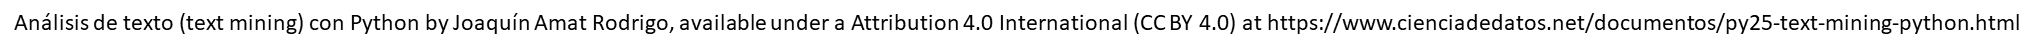